<a href="https://colab.research.google.com/github/yaakitori/GNN_tutorial/blob/main/gat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks



*   GCNを改良したもの
*   静的な正規化の代わりに，アテンションによる動的な正規化



In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


https://pypi.org/project/torchinfo/

In [ ]:
pip install torchinfo

## グラフアテンションレイヤーの紹介



*   GCNでは近傍は正規化係数から次数が少ない頂点が多い頂点より重要であるとした．これには表現力に限界がある

*   GATは頂点の特徴の重要性を考慮した重みづけ係数を生成できる
*   重みづけ係数はアテンションスコアと呼ばれる





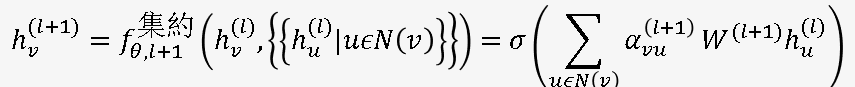

アテンションスコアを4ステップで計算する方法とGATレイヤーを改善する方法を見ていく



1.   線形変換
2.   アクティベーション機能
3. ソフトマックス関数
4. マルチヘッドアテンション
5. GATレイヤーの改善


1. 線形変換
2. アクティベーション機能

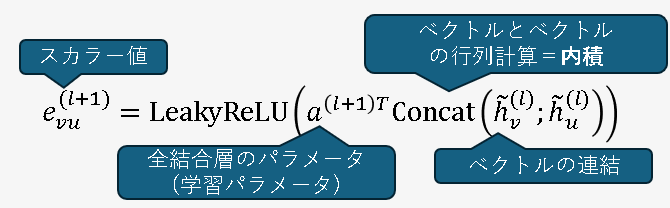

v：中央頂点

u：隣接頂点

e：アテンションスコア

a:アテンションスコアを計算するための重み

連結され，活性化関数に与えられる

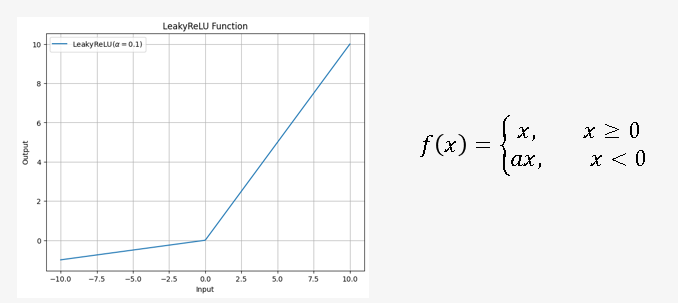

3. ソフトマックス関数

softmax関数によりスケールをそろえる

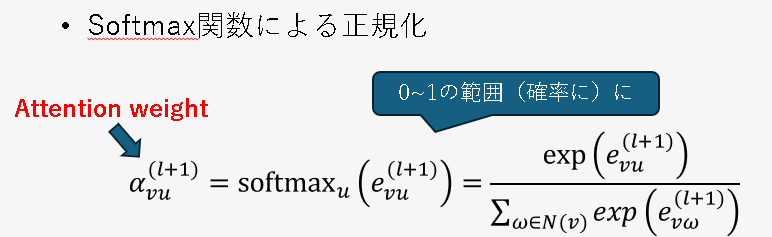

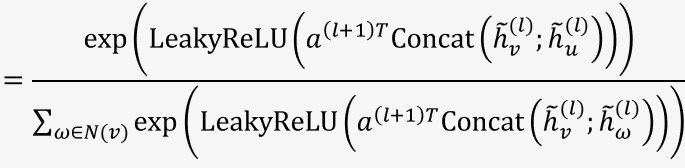

GCNと同様に隣接頂点には自分自身も含む

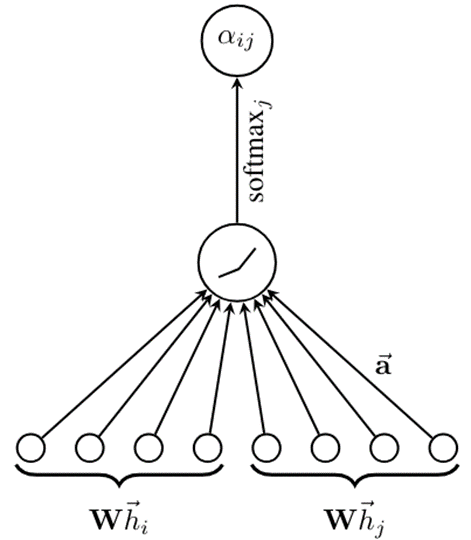

4. マルチヘッドアテンション

アテンションを複数利用することに精度が上がることが報告されている

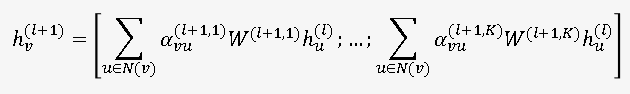

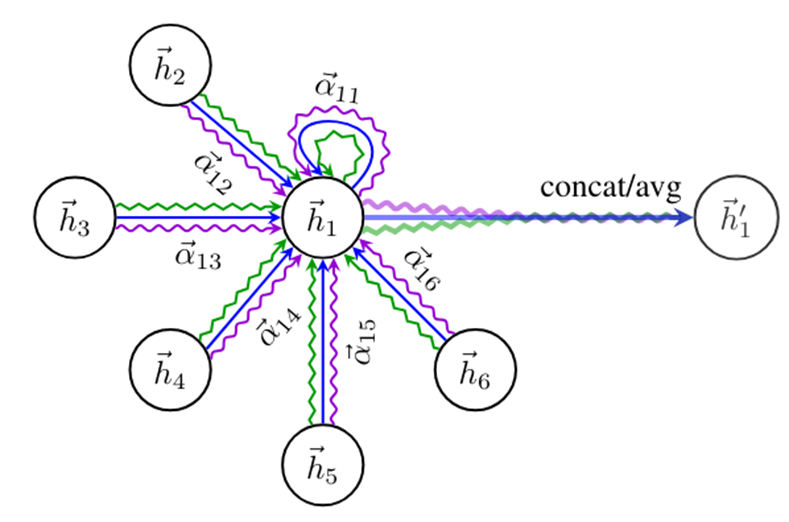

マルチヘッドアテンションは，中間層では結合される．最終層で平均がとられて元の次元に戻る

 5. GATレイヤーの改善（GATv2）



*   操作の順番を変えたモデル
*   重み行列Wが連結の後に適用され，アテンション重み行列aがLekyReLUのあとに適用される


*   通常のGATよりも性能が良い

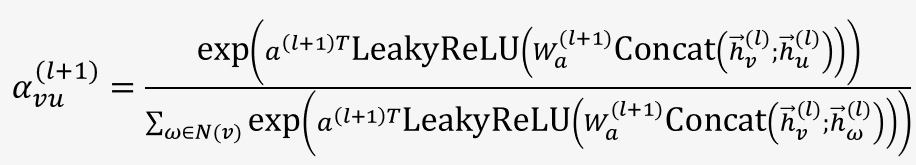

## 以下の図について考えていく


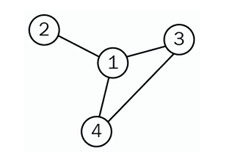

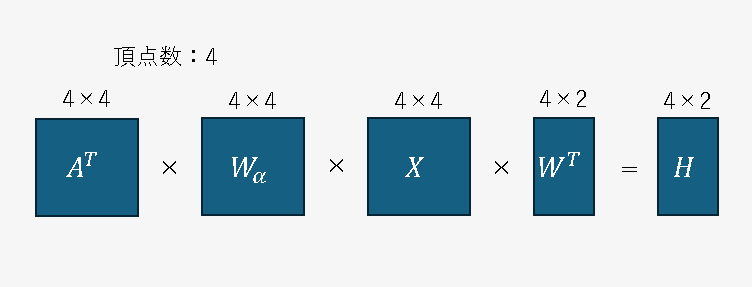

4次元の特長量を2次元に

In [ ]:
import numpy as np
np.random.seed(0)

# 隣接行列（タプル）
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [ ]:
# 頂点特徴量
# -1～1の範囲，4×4の行列
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

In [ ]:
# 通常の重み行列　（任意の次元数，ノード数）
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

Attention weightを求める

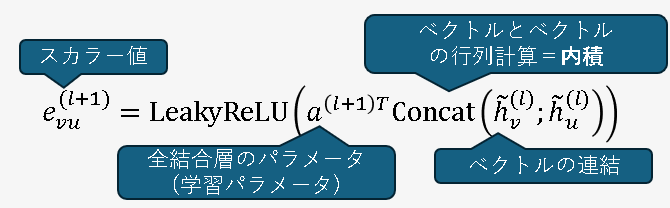

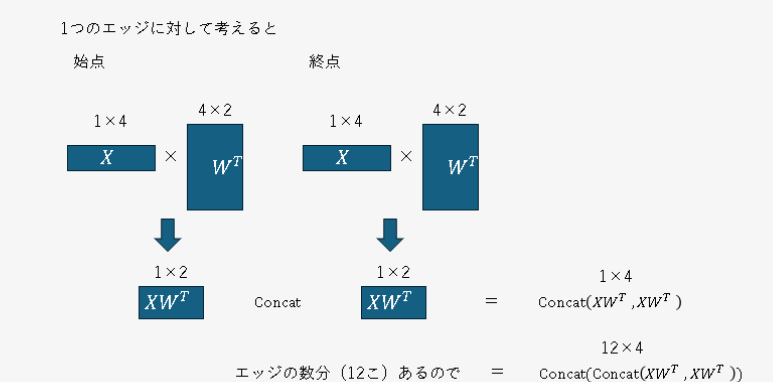

In [ ]:
# アテンション行列　（1，隠れ層の次元×2）
# 中心頂点の表現と隣接頂点の表現が連結されるため隠れ層の次元×2になる
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783]])

In [ ]:
# np.whereにより隣接行列から1以上の要素のインデックスのリストを取得
# つまり，エッジのリスト（始点，終点）
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [ ]:
len(connections[0])

12

In [ ]:
connections[0][0]

0

In [ ]:
connections[1][0]

0

In [ ]:
X @ W.T

array([[ 0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279],
       [-0.67755906,  0.73566587],
       [-0.65268413,  0.24235977]])

In [ ]:
# 隣接頂点と中心頂点の表現を連結
# エッジリスから1列ごと取り出し連結
# 隠れ層の次元が2のため，X @ W.Tの列方向は2次元．横方向に結合すると合計4次元
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [ ]:
len(np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1))

12

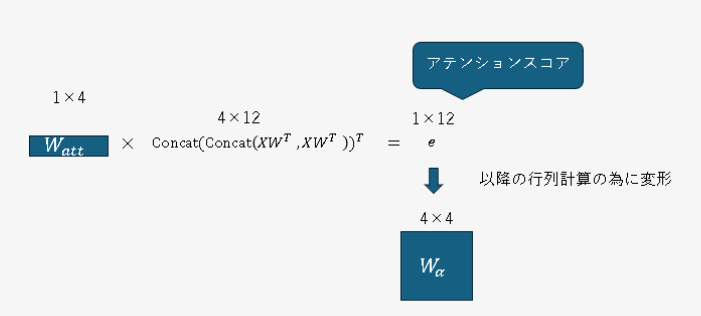

In [ ]:
# 先ほどの結果にアテンション行列をかける
# 1×4の行列と4×12の行列の積
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [ ]:
len(a[0])

12

In [ ]:
# Leaky_ReLUを適用
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [ ]:
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [ ]:
# エッジのリストから隣接行列の形状に直す
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

In [ ]:
# アテンションスコアの各行を正則化
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

# softmaxによりアッテンション重みに
W_alpha = softmax2D(E, 1)
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

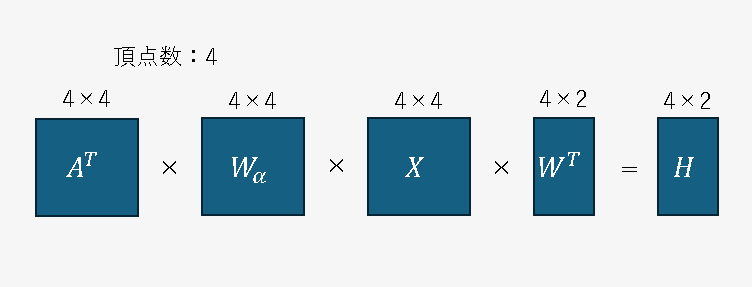

In [ ]:
# 中間表現の計算
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])

## Pytorch GeometricでのGATの実装

### Coraデータセットで実装

Case_Based,
Generic_Algorithms,
Neural_Networks,
Probabilistic_Methods,
Reinforcement_Learning,
Rule_Learning,
Theory

In [ ]:
# ライブラリのインポート
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

In [ ]:
# データセットのインポート
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [ ]:
# グラフの情報を表示するための関数
def graph_info(data):

    print("ノードの数:", data.num_nodes)
    print("エッジの数:", data.num_edges)
    print("特徴量の数:", data.num_node_features)
    print("無向グラフか？:", data.is_undirected())
    print("孤立したノードが有るか？:", data.has_isolated_nodes())
    print("自己ループがあるか？:", data.has_self_loops())

    print()

    print("キー: ", data.keys)
    print("各ノードの特徴量")
    print(data["x"][0,:100]) # 最初の頂点の特徴量のうち100個のみ表示
    print("各ノードのラベル")
    print(data["y"][:100]) # 先頭100個のみ表示
    print("各エッジ")
    print(data["edge_index"][:,:20]) # 先頭20個のみ表示
    print("train_mask")
    print(data["train_mask"][:20]) # 先頭20個のみ表示

In [ ]:
graph_info(data)

ノードの数: 2708
エッジの数: 10556
特徴量の数: 1433
無向グラフか？: True
孤立したノードが有るか？: False
自己ループがあるか？: False

キー:  ['edge_index', 'x', 'test_mask', 'train_mask', 'val_mask', 'y']
各ノードの特徴量
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
各ノードのラベル
tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2, 0, 0, 4, 3, 3, 3, 2, 3, 1, 3, 5, 3, 4, 6,
        3, 3, 6, 3, 2, 4, 3, 6, 0, 4, 2, 0, 1, 5, 4, 4, 3, 6, 6, 4, 3, 3, 2, 5,
        3, 4, 5, 3, 0, 2, 1, 4, 6, 3, 2, 2, 0, 0, 0, 4, 2, 0, 4, 5, 2, 6, 5, 2,
        2, 2, 0, 4, 5, 6, 4, 0, 0, 0, 4, 2, 4, 1, 4, 6, 0, 4, 2, 4, 6, 6, 0, 0,
        6, 5, 0, 6])
各エッジ
tensor([[   0,    0,    0,  

In [ ]:
# 評価用関数を定義
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
# GATの構成定義
class GAT(torch.nn.Module):
    # インスタンスを初期化
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads) # GATv2Conv(入力数, 出力数, アテンションヘッドの数)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1) # 二層目の入力は dim_h*heads（ヘッド数分連結されるため）
        # 一層目にヘッド数を8にすることで精度が上がることが報告された
        # 二層目のヘッド数は精度に影響を与えないと報告された

    # 順伝播
    # 過学習を防ぐために2つのドロップアウトを追加（いくつかのニューロンを0に）
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training) # ノードの特徴量とエッジの情報を使って畳み込み
        h = self.gat1(h, edge_index)
        h = F.elu(h) # 元論文に従い，ELU関数を活性化関数に（負の領域でなめらかな曲線）
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    # 訓練関数
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss() # 損失関数を交差エントロピー誤差に
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01) # 最適化アルゴリズムの選択

        self.train() # 訓練モード
        for epoch in range(epochs+1):
            optimizer.zero_grad() # 勾配の初期化(pytorchでは勾配が累積してしまうため)
            out = self(data.x, data.edge_index) # 順伝播により予測値を得る
            # 転導的学習のためすべてのノードを含む。train用ノード（クラスが分かっているノードのみ）を使い誤差を計算
            loss = criterion(out[data.train_mask], data.y[data.train_mask]) # 予測値と正解値から誤差を計算
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask]) # 正解率を計算
            loss.backward() # 誤差からバックプロパゲーションにより勾配を計算
            optimizer.step()  # 最適化アルゴリズムによりパラメータを更新

            if(epoch % 20 == 0): # 20エポックごとに検証
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    # テスト関数
    @torch.no_grad() # 推論のためオートグラフ（自動微分）機能を無効に
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        # テストデータに対する予測値を得る、argmaxで最大値のインデックスを取得
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc, out

In [ ]:
# モデルの定義
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)


In [ ]:
from torchinfo import summary
summary(gat, input_data=(data.x, data.edge_index))

Layer (type:depth-idx)                   Output Shape              Param #
GAT                                      [2708, 7]                 --
├─GATv2Conv: 1-1                         [2708, 256]               512
│    └─Linear: 2-1                       [2708, 256]               367,104
│    └─Linear: 2-2                       [2708, 256]               367,104
│    └─SumAggregation: 2-3               [2708, 8, 32]             --
├─GATv2Conv: 1-2                         [2708, 7]                 14
│    └─Linear: 2-4                       [2708, 7]                 1,799
│    └─Linear: 2-5                       [2708, 7]                 1,799
│    └─SumAggregation: 2-6               [2708, 1, 7]              --
Total params: 738,332
Trainable params: 738,332
Non-trainable params: 0
Total mult-adds (G): 2.00
Input size (MB): 15.69
Forward/backward pass size (MB): 11.40
Params size (MB): 2.95
Estimated Total Size (MB): 30.04

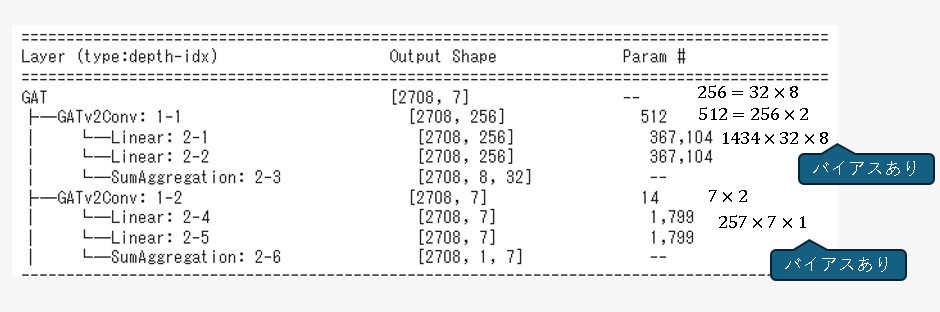

In [ ]:
# Train
%time gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch  60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch  80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.20%
CPU times: user 31.4 s, sys: 766 ms, total: 32.2 s
Wall time: 50.5 s


In [ ]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc[0]*100:.2f}%')

GAT test accuracy: 82.00%


In [ ]:
# 0番目の頂点に対する予測値
acc[1][0]

tensor([-5.8712, -4.5784, -4.1236, -0.0690, -3.5473, -5.8347, -5.1712])

In [ ]:
acc[1][0].argmax()

tensor(3)

In [ ]:
# 0番目の頂点の正解ラベル(上と一致)
data["y"][0]

tensor(3)

### CiteSeerデータセットで実装

[CiteSeer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html?highlight=CiteSeer%20)



*   各接続が引用である研究論文のネットワーク
*   各頂点の特徴量は，論文内の単語の存在(1)不在(0)を表す
*   ノード分類を扱う
*   6つのカテゴリが存在（Agents, AI, DB, IR, ML, HCI）

https://citeseerx.ist.psu.edu/

コンピュータサイエンスと情報科学の学術論文を収集・検索するデジタルライブラリと検索エンジン

https://dl.acm.org/doi/pdf/10.1145/276675.276685

https://ieeexplore.ieee.org/document/6316639/references#references

↑元論文

ステミングとストップワードの除去を行い、さらに文書頻度が10未満の単語を削除

In [ ]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
graph_info(data)

ノードの数: 3327
エッジの数: 9104
特徴量の数: 3703
無向グラフか？: True
孤立したノードが有るか？: True
自己ループがあるか？: False

キー:  ['edge_index', 'x', 'test_mask', 'train_mask', 'val_mask', 'y']
各ノードの特徴量
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
各ノードのラベル
tensor([3, 1, 5, 5, 3, 1, 3, 0, 3, 5, 2, 4, 2, 1, 2, 3, 2, 4, 4, 0, 1, 5, 5, 3,
        5, 2, 5, 2, 4, 2, 2, 2, 4, 5, 2, 3, 4, 5, 3, 3, 2, 1, 2, 1, 5, 1, 1, 4,
        2, 3, 3, 2, 5, 2, 5, 1, 4, 1, 4, 2, 2, 3, 4, 5, 5, 1, 3, 3, 4, 2, 4, 1,
        1, 5, 0, 2, 0, 3, 5, 2, 4, 1, 1, 4, 4, 0, 4, 4, 5, 3, 5, 5, 4, 5, 3, 1,
        4, 4, 3, 1])
各エッジ
tensor([[   0,    1,    1,    1,    1,

Coraと比べノード数や特徴量の数が増えている

<BarContainer object of 32 artists>

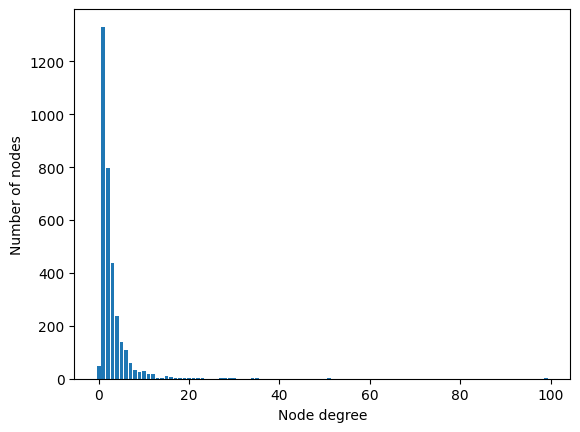

In [ ]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

一部の頂点の次数が0

孤立した頂点の予測は難しい

In [ ]:
# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc[0]*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.814 | Train Acc: 13.33% | Val Loss: 1.81 | Val Acc: 17.00%
Epoch  20 | Train Loss: 0.153 | Train Acc: 97.50% | Val Loss: 1.14 | Val Acc: 60.80%
Epoch  40 | Train Loss: 0.136 | Train Acc: 98.33% | Val Loss: 1.16 | Val Acc: 60.60%
Epoch  60 | Train Loss: 0.158 | Train Acc: 98.33% | Val Loss: 1.29 | Val Acc: 58.60%
Epoch  80 | Train Loss: 0.118 | Train Acc: 98.33% | Val Loss: 1.18 | Val Acc: 60.60%
Epoch 100 | Train Loss: 0.109 | Train Acc: 98.33% | Val Loss: 1.13 | Val Acc: 66.20%
GAT test accuracy: 67.70%


GCNよりもわずかに優れる

In [ ]:
summary(gat, input_data=(data.x, data.edge_index))

Layer (type:depth-idx)                   Output Shape              Param #
GAT                                      [3327, 6]                 --
├─GATv2Conv: 1-1                         [3327, 128]               256
│    └─Linear: 2-1                       [3327, 128]               474,112
│    └─Linear: 2-2                       [3327, 128]               474,112
│    └─SumAggregation: 2-3               [3327, 8, 16]             --
├─GATv2Conv: 1-2                         [3327, 6]                 12
│    └─Linear: 2-4                       [3327, 6]                 774
│    └─Linear: 2-5                       [3327, 6]                 774
│    └─SumAggregation: 2-6               [3327, 1, 6]              --
Total params: 950,040
Trainable params: 950,040
Non-trainable params: 0
Total mult-adds (G): 3.16
Input size (MB): 49.43
Forward/backward pass size (MB): 7.13
Params size (MB): 3.80
Estimated Total Size (MB): 60.36

仮説検証：頂点の次数が少ないと精度が悪くなる？？

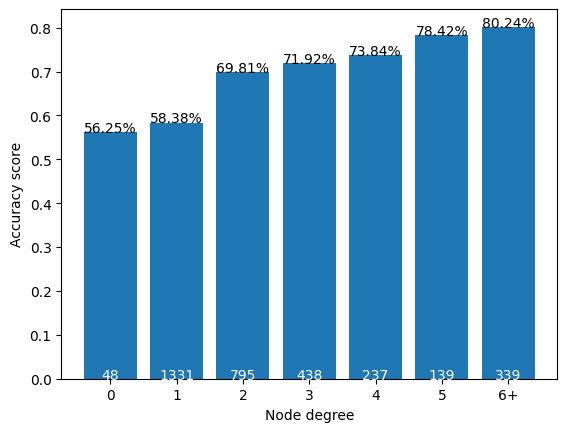

In [ ]:
# 各頂点の次数の平均精度をプロット
# Get model's classifications
out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

結果：次数が多くなるほど精度が良い